In [1]:
import plotly
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D
from scipy.signal import fftconvolve
from sklearn.svm import LinearSVC
from itertools import *
from joblib import Parallel, delayed

!git clone https://github.com/HNinou/MathTools_TD2
!unzip MathTools_TD2/dic_cont8_GO.npy.zip -d MathTools_TD2/

Cloning into 'MathTools_TD2'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 16.96 MiB | 34.80 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Archive:  MathTools_TD2/dic_cont8_GO.npy.zip
  inflating: MathTools_TD2/dic_cont8_GO.npy  
  inflating: MathTools_TD2/__MACOSX/._dic_cont8_GO.npy  


The cell below generates the data and stores it in the matrix X

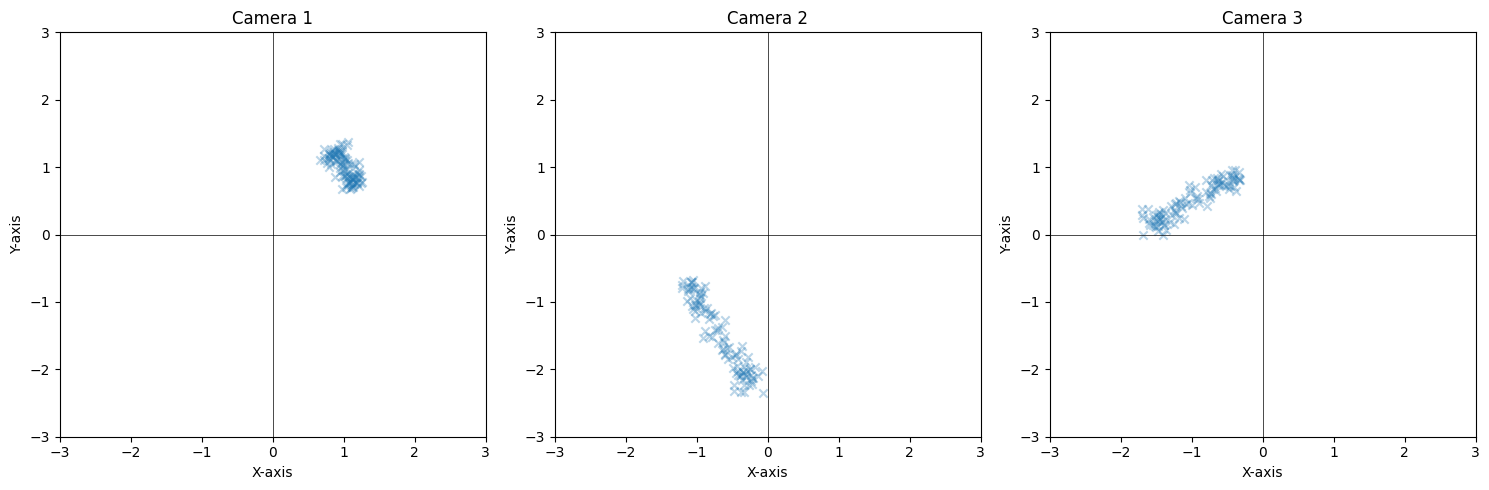

In [2]:
def generate_spring_data(nb_timesteps, noise_level):
    nb_timesteps = int(nb_timesteps)

    x = np.cos(np.linspace(0, np.pi, num = nb_timesteps))
    y = np.zeros(nb_timesteps)

    x += np.random.normal(0, noise_level, size = nb_timesteps)
    y += np.random.normal(0, noise_level, size = nb_timesteps)

    return (x,y)

def rotate_data(x,y, theta, phi):
    return (x*np.cos(phi)*np.cos(theta)+y*np.sin(theta), -x*np.cos(phi)*np.sin(theta)+y*np.cos(theta))


nb_timesteps=int(1e2)
noise_level=0.1
x_ini,y_ini = generate_spring_data(nb_timesteps, noise_level)

X = np.zeros((6,int(nb_timesteps)))

theta1 = np.pi/3
phi1 = 2*np.pi/5

theta2 = -2*np.pi/3
phi2 = np.pi/6

theta3 = -np.pi/6
phi3 = -np.pi/4

angle_list =  [(theta1,phi1), (theta2,phi2), (theta3,phi3)]
offset_list = [(1,1),(-2/3,-3/2),(-1,1/2)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (theta, phi) in enumerate(angle_list):
    # Get the current subplot
    ax = axes[i]

    # Calculate rotated data
    x = rotate_data(x_ini, y_ini, theta, phi)[0] + offset_list[i][0]
    X[i] = x
    y = rotate_data(x_ini, y_ini, theta, phi)[1] + offset_list[i][1]
    X[i+3] = y

    # Plot on the current subplot
    ax.scatter(x, y, marker='x', alpha=0.3)

    # Set axis limits and labels
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title(f"Camera {i + 1}")
    ax.axhline(0, color='black', linewidth=0.5)  # Horizontal axis at y=0
    ax.axvline(0, color='black', linewidth=0.5)  # Vertical axis at x=0


# Display the plots
plt.tight_layout()
plt.show()

## 4)

In [3]:
C = (X@X.T)/nb_timesteps
eigval, eigvec = np.linalg.eigh(C)

## 5)

Text(0.5, 1.0, 'Eigenvalues')

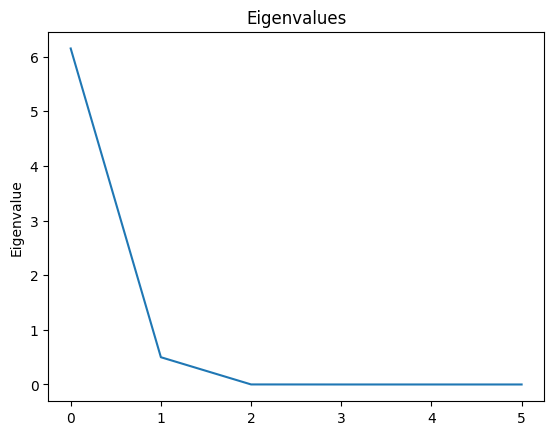

In [4]:
plt.plot(eigval[::-1])
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues')

Text(0, 0.5, 'PC2')

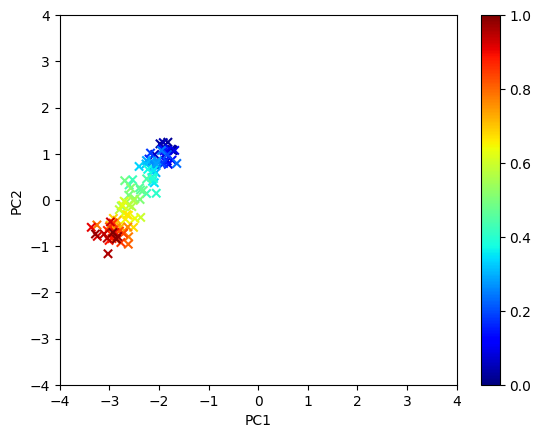

In [5]:
PC1 = eigvec[:,-1]
PC2 = eigvec[:,-2]

plt.scatter(PC1@X, PC2@X, marker = 'x', cmap = 'jet', c=np.linspace(0,1, num =nb_timesteps))
plt.colorbar()
plt.ylim((-4,4))
plt.xlim((-4,4))
plt.xlabel('PC1')
plt.ylabel('PC2')


## 6)

In [6]:
X_centered = X - X.mean(axis=1)[:,None]
C_c = (X_centered@X_centered.T)/nb_timesteps
eigval_c, eigvec_c = np.linalg.eigh(C_c)

Text(0.5, 1.0, 'Eigenvalues')

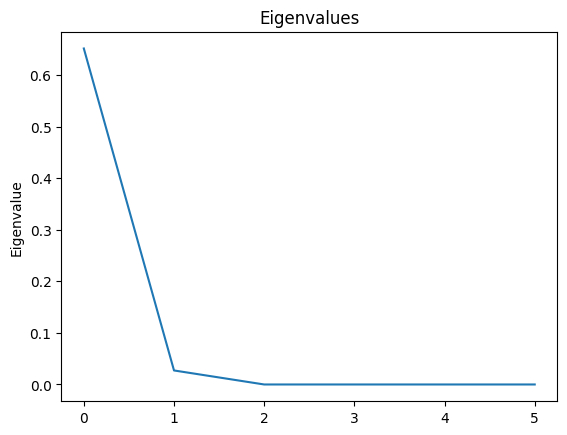

In [7]:
plt.plot(eigval_c[::-1])
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues')

Text(0, 0.5, 'PC2')

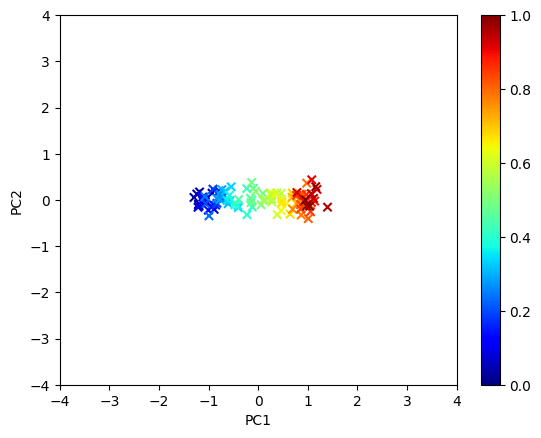

In [8]:
PC1_c = eigvec_c[:,-1] #check it
PC2_c  = eigvec_c[:,-2]

plt.scatter(PC1_c@X_centered, PC2_c@X_centered, marker = 'x', cmap = 'jet', c=np.linspace(0,1, num =nb_timesteps))
plt.colorbar()
plt.ylim((-4,4))
plt.xlim((-4,4))
plt.xlabel('PC1')
plt.ylabel('PC2')

## 7)

In [9]:
print(np.var(PC1_c@X_centered), eigval_c[-1])

0.6513060748225419 0.6513060748225419


##8)

In [10]:
print(np.var(PC2_c@X_centered), eigval_c[-2])

0.02717878583110356 0.02717878583110355


## 9)


In [11]:
U,S,Vh = np.linalg.svd(X_centered, full_matrices = False)

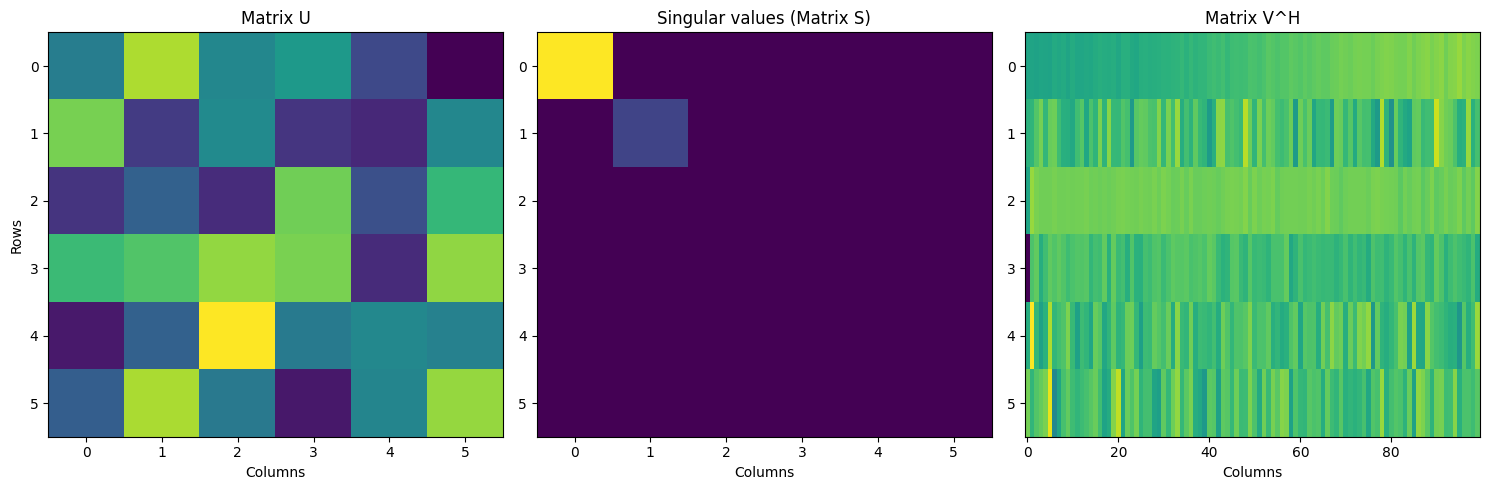

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display matrix U
axes[0].imshow(U, cmap='viridis', aspect='auto')
axes[0].set_title("Matrix U")
axes[0].set_xlabel("Columns")
axes[0].set_ylabel("Rows")

# Display singular values as a diagonal matrix S
S_matrix = np.diag(S)
axes[1].imshow(S_matrix, cmap='viridis', aspect='auto')
axes[1].set_title("Singular values (Matrix S)")
axes[1].set_xlabel("Columns")

# Display matrix V^H
axes[2].imshow(Vh, cmap='viridis', aspect='auto')
axes[2].set_title("Matrix V^H")
axes[2].set_xlabel("Columns")

# Adjust layout
plt.tight_layout()
plt.show()

## 10)

In [13]:
data_UT_X_centered = U.T @ X_centered #me right
data_S_Vh = np.diag(S) @ Vh

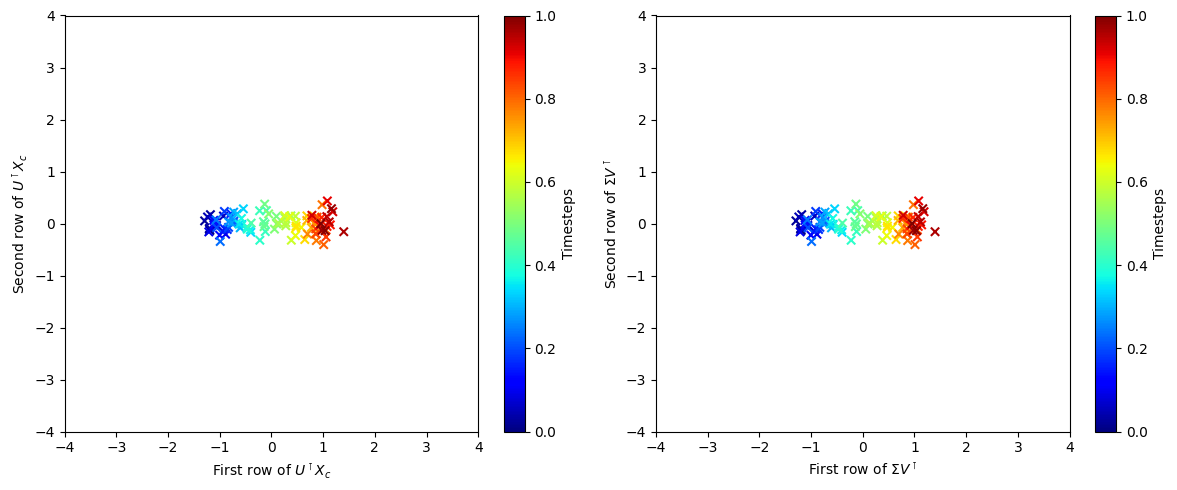

In [14]:

color_values = np.linspace(0, 1, num=nb_timesteps)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First plot: U.T @ X_centered
scatter1 = axes[0].scatter(data_UT_X_centered[0], data_UT_X_centered[1],
                           marker='x', cmap='jet', c=color_values)
axes[0].set_ylim(-4, 4)
axes[0].set_xlim(-4, 4)
axes[0].set_xlabel('First row of $U^\\intercal X_c$')
axes[0].set_ylabel('Second row of $U^\\intercal X_c$')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Timesteps')

# Second plot: np.diag(S) @ Vh
scatter2 = axes[1].scatter(data_S_Vh[0], data_S_Vh[1],
                           marker='x', cmap='jet', c=color_values)
axes[1].set_ylim(-4, 4)
axes[1].set_xlim(-4, 4)
axes[1].set_xlabel('First row of $\\Sigma V^\\intercal$')
axes[1].set_ylabel('Second row of $\\Sigma V^\\intercal$')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Timesteps')

# Adjust layout
plt.tight_layout()
plt.show()

# Performing PCA on neural data


In [15]:
def gaussian(x, sigma, mu=0):
    return np.exp(-((x-mu)**2) / (2*sigma**2))

def make_conv_kernel( sigma= 30):
    nb_time_frames = 6*sigma
    conv_kernel = gaussian(np.arange(-nb_time_frames//2,nb_time_frames//2,1), sigma=sigma)
    conv_kernel /= np.sum(conv_kernel)

    return conv_kernel

def smoothen_data(dic, sigma=30):
    # Get number of neurons
    nb_neurons = len(dic['mat'])

    # Create the convolution kernel
    conv_kernel = make_conv_kernel(sigma=sigma)

    # Pre-allocate the smooth_mat with the same structure as dic['mat']
    smooth_mat = [None] * nb_neurons

    # Loop over neurons, but vectorize across trials
    for neuron in range(nb_neurons):
        # Get all trials for this neuron as a 2D matrix (nb_trials, time_points)
        mat_neuron = dic['mat'][neuron]

        # Use fftconvolve for faster convolution across all trials
        smooth_neuron = fftconvolve(mat_neuron, conv_kernel[None, :], mode='same', axes=1)

        # Store the result back
        smooth_mat[neuron] = smooth_neuron

    # Replace the original matrix with the smoothed data
    dic['sm_mat'] = smooth_mat
    return dic


def raster_plot(neural_data):
  # Create the raster plot using Plotly
  fig = go.Figure(data=go.Heatmap(
      z=neural_data,
      colorscale='Greys',
      colorbar=dict(
          title="Neural Activity",
          titleside='right',
          ticks='outside',
          ticklen=5,
          tickcolor='black',
      )
  ))

  fig.update_layout(
      title="Neural Activity Raster Plot",
      xaxis=dict(
          title="Time (ms)",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      yaxis=dict(
          title="Trial Index",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      plot_bgcolor='white',
      font=dict(size=14),
  )

  # Display the plot
  fig.show()
  return()

The cell below stores the data in the dictionnary dic_cont8. The raw data is stored in dic_cont8['mat'] which is a list of size 777, that is the total number of neurons. Each element of this list contains a matrix of size (#trials x #timesteps). For each recording, that is for each trial, the data is shifted so that the 'GO' signal always shows up at the 2000th time frame.

In [16]:
# Load the data from the .npy files

centering = 'GO'
dic_cont8 =np.load('MathTools_TD2/dic_cont8_GO.npy', allow_pickle = True).flat[0]
# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)

nb_neurons = len(dic_cont8['target'])

nb_trials_cont8 = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_cont8[i] = dic_cont8['target'][i].shape[0]

In [17]:
dic_cont8.keys()

dict_keys(['mat', 'target', 'cont_filter', 'cue', 'endoft', 'sm_mat'])

In [18]:
dic_cont8['mat'][0].shape

(271, 4001)

##1)

The cell below shows the raster plot of neuron 0

In [19]:
neural_data = dic_cont8['mat'][0]  # Shape: (271, 4001)

raster_plot(neural_data)


Output hidden; open in https://colab.research.google.com to view.

The cell below does the same plot for the smoothened data that is stored in dic_cont8['sm_mat']

In [20]:
neural_data_smooth = dic_cont8['sm_mat'][0]  # Shape: (271, 4001)

raster_plot(neural_data_smooth)

Output hidden; open in https://colab.research.google.com to view.

For each neuron and each trial, the id of the cued target is stored in dic_cont8['target'].

Be careful, the lists of cued targets are not the same going from one neuron to another !

The above raster plot combines the smoothened neural activity for all targets.

##2)
Type your code below

In [21]:
dic_cont8['target'][0]
np.unique(dic_cont8['target'][0])

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)

In [22]:
matrices_neuron_0 = {}

for i in np.unique(dic_cont8['target'][0]):
    matrices_neuron_0[f'matrix_{i}'] = dic_cont8['mat'][0][dic_cont8['target'][0] == i] #for each target, a key associated
    print(f'Neural Activity Raster Plot for the target {i}')
    raster_plot(matrices_neuron_0[f'matrix_{i}'])

# smoothened data:

for i in np.unique(dic_cont8['target'][0]):
    matrices_neuron_0[f'matrix_{i}'] = dic_cont8['sm_mat'][0][dic_cont8['target'][0] == i] #for each target, a key associated
    print(f'Neural Activity Raster Plot (smoothened data) for the target {i}')
    raster_plot(matrices_neuron_0[f'matrix_{i}'])



Output hidden; open in https://colab.research.google.com to view.

##3)
Type your code below

In [23]:
nb_trials = [matrix.shape[0] for matrix in dic_cont8['mat']]

The cell below shows a histogram of nb_trials

In [24]:
nb_trials = np.array(nb_trials)

# Create a histogram with Plotly
fig = go.Figure()

# Add the histogram
fig.add_trace(go.Histogram(
    x=nb_trials,
    nbinsx=50,  # Adjust the number of bins to suit the distribution
    marker_color='rgba(0, 128, 255, 0.7)',
    opacity=0.75,
    histnorm='probability',  # Normalized to show probability density
))



# Customize the layout for a clean, publication-quality appearance
fig.update_layout(
    title="Distribution of nb_trials",
    xaxis=dict(
        title="Number of trials",
        showgrid=True,
        gridcolor='rgba(230,230,230,0.5)',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside'
    ),
    yaxis=dict(
        title="Density",
        showgrid=True,
        gridcolor='rgba(230,230,230,0.5)',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside'
    ),
    font=dict(size=16),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False,
    width = 800,
    height = 600
)

# Update the color of the bins for a more refined palette
fig.update_traces(marker_line_color='black',  # Bin border color
                  marker_line_width=1.5)     # Bin border width

# Show the plot
fig.show()


##4)
Type your code below

In [25]:
nb_neurons= len(dic_cont8['mat'])
nb_trials_per_c = np.zeros((8,nb_neurons))

...



# first I create a super dictionnary
neurons_targetted = {}
neuron_index = -1
for neuron in dic_cont8['mat']:
  neuron_index += 1
  # I create a dictionnary in which each key is a target and corresponds to the matrix (nb_trials for this target x nb_timesteps)
  for target in np.unique(dic_cont8['target'][neuron_index]):
    # I add to my dictionnary a key (a given target for a given neuron), and its value (a matrix of size nb_trials for this target x nb_timesteps)
    neurons_targetted[f'neuron_{neuron_index + 1}_target_{target}'] = neuron[dic_cont8['target'][neuron_index] == target]
    # then I fill the matrix nb_trials_per_c
    nb_trials_per_c[target - 1][neuron_index] = neurons_targetted[f'neuron_{neuron_index + 1}_target_{target}'].shape[0]

print(nb_trials_per_c[:,0])



[35. 35. 31. 34. 35. 29. 37. 35.]


The cell below plots these distributions.

In [26]:
colors = np.array([(85, 107, 194), (0, 182, 212), (74, 205, 152),(115, 169, 8), (245, 185, 0), (244, 120, 0), (223, 47, 47), (194, 85, 161)]) # ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']


for target in range(8):

  mean_value = np.mean(nb_trials_per_c[target])

  # Create a histogram with Plotly
  fig = go.Figure()

  # Add the histogram
  fig.add_trace(go.Histogram(
      x=nb_trials_per_c[target],
      nbinsx=50,  # Adjust the number of bins to suit the distribution
      marker_color=plotly.colors.label_rgb(colors[target]),
      opacity=0.75,
      histnorm='probability',  # Normalized to show probability density
      name = 'target %s'%(target+1)
  ))

      # Add a vertical line at the mean value
  fig.add_trace(go.Scatter(
        x=[mean_value, mean_value],
        y=[0, 0.1],  # This extends the line from the bottom to the top of the plot
        mode="lines",
        line=dict(color="red", width=2, dash="dash"),  # Customize line appearance
        name="Mean",
        showlegend = True
  ))

  # Customize the layout for a clean, publication-quality appearance
  fig.update_layout(
      title="Distribution of nb_trials",
      xaxis=dict(
          title="Number of trials",
          showgrid=True,
          gridcolor='rgba(230,230,230,0.5)',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True,
          ticks='outside'
      ),
      yaxis=dict(
          title="Density",
          showgrid=True,
          gridcolor='rgba(230,230,230,0.5)',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True,
          ticks='outside'
      ),
      font=dict(size=16),
      plot_bgcolor='white',
      paper_bgcolor='white',
      showlegend=True,
      width = 800,
      height = 600
  )

  # Update the color of the bins for a more refined palette
  fig.update_traces(marker_line_color='black',  # Bin border color
                    marker_line_width=1.5)     # Bin border width

  # Show the plot
  fig.show()

##5)
Type your code below

In [27]:
X = []

...
for neuron in dic_cont8['sm_mat']: #smoothened data
  if neuron.shape[0] >= 100:
    neuron = neuron[:100]
    X.append(neuron.flatten())
X = np.array(X)
X.shape

(652, 400100)

##6)
Type your code below

In [28]:
...# PAS BON LA DIVISION

X_centered = X - X.mean(axis=1)[:,None] #do we have to center the data?
# C = (X_centered@X_centered.T)/nb_trials_cont8.sum() # HEIN ??????????? sur quoi ? what about 100 now ?

C = (X_centered@X_centered.T)/400100
eigval, eigvec = np.linalg.eigh(C)

print(nb_trials_cont8.sum())



124373.0


Remember that when using np.linalg.eigh(), the eigenvalues should be stored from lowest to highest.

In [29]:
PC1 = eigvec[:,-1]
PC2 = eigvec[:,-2]
PC3 = eigvec[:,-3]

The cell below shows the data projected along the firsts 3 PCs

In [30]:
import plotly.graph_objects as go

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(PC1 @ X)[::100],
    y=(PC2 @ X)[::100],
    z=(PC3 @ X)[::100],
    mode='markers',
    marker=dict(size=4, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


It's hard to tell anything from this plot. One thing we could do is color code the plot by having a different color for each time bin

In [31]:
times = np.zeros(4001*100)
for trial in range(100):
  times[4001*trial:(trial+1)*4001] = np.linspace(0,1, 4001)
times.shape

(400100,)

In [32]:
import plotly.graph_objects as go

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(PC1 @ X)[::100],
    y=(PC2 @ X)[::100],
    z=(PC3 @ X)[::100],
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Agsunset',
                  color = times[::100],
                  colorbar = dict(title ='Time',
                                  titleside = 'top',
                                  tickvals = [0,1],
                                  ticktext=['Early','Late'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()



Our first two principal components seem to capture the variance in neural activity that's related to the time in the trial.

We would therefore like to plot the neural activity corresponding to a specific target being cued to the monkey.



In [33]:
dic_cont8['target'][0][:100] #100 first targets (100 trials) for the neuron 0

array([1, 6, 6, 2, 5, 3, 3, 7, 7, 8, 5, 2, 8, 5, 2, 3, 3, 1, 3, 2, 4, 5,
       2, 3, 6, 3, 3, 4, 8, 7, 3, 6, 6, 5, 5, 7, 5, 8, 5, 5, 8, 7, 5, 1,
       8, 8, 4, 7, 4, 2, 1, 6, 6, 2, 7, 4, 3, 5, 4, 7, 6, 7, 7, 1, 1, 5,
       8, 1, 2, 7, 8, 2, 4, 4, 3, 6, 4, 5, 1, 1, 4, 2, 8, 6, 8, 7, 8, 1,
       2, 1, 2, 5, 6, 7, 5, 7, 2, 8, 4, 2], dtype=uint8)

This shows the cued targets for the first 100 trials of neuron 0.

Below are the cued targets for the first 100 trials of neuron 2.

In [34]:
dic_cont8['target'][2][:100]

array([8, 6, 5, 4, 4, 5, 3, 6, 8, 6, 3, 3, 7, 6, 1, 4, 3, 3, 7, 1, 6, 5,
       5, 1, 8, 5, 4, 6, 7, 3, 3, 6, 7, 4, 4, 2, 5, 5, 2, 2, 4, 6, 6, 7,
       8, 6, 8, 3, 2, 6, 4, 7, 6, 7, 2, 5, 1, 1, 3, 5, 7, 3, 5, 3, 3, 4,
       3, 3, 1, 1, 7, 8, 6, 1, 5, 8, 7, 8, 7, 5, 6, 2, 2, 3, 8, 8, 2, 5,
       4, 1, 6, 4, 2, 2, 1, 4, 5, 1, 1, 1], dtype=uint8)

##7)

Type your code below

In [35]:
neuron_filter_ct = np.zeros(nb_neurons) == 0
nb_valid_neurons = 0 #énoncé
nb_valid_neurons = nb_neurons
print(nb_valid_neurons)

...

print(np.unique(dic_cont8['target'][0]))
# build a filter for neurons that at least 12 trials for each cued targets
# filter = array of size nb_neurons (true or false if neuron have 12 trials for each of the 8 cued target - false otherwisqe)

for neuron in range(nb_trials_per_c.shape[1]):
  for target in range(nb_trials_per_c.shape[0]):
    if nb_trials_per_c[target][neuron] < 12:
      neuron_filter_ct[neuron] = False
      nb_valid_neurons -= 1
      break

print(neuron_filter_ct)
print(nb_valid_neurons)

# GPT solution (plus rapide)
# # Filtrer les neurones avec au moins 12 essais pour chaque cible
# neuron_filter_ct = np.all(nb_trials_per_c >= 12, axis=0)  # Vérifie si toutes les cibles d'un neurone ont >= 12 essais
# nb_valid_neurons = np.sum(neuron_filter_ct)  # Compte le nombre de neurones valides

# # Affichage des résultats
# print(neuron_filter_ct)  # Tableau de booléens
# print(nb_valid_neurons)  # Nombre total de neurones valides





777
[1 2 3 4 5 6 7 8]
[ True False False  True  True  True False  True  True  True  True  True
 False  True  True  True  True  True False False False  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True False  True  True False  True False  True False
  True  True  True  True  True False  True  True False  True  True  True
  True False  True  True  True  True  True  True  True  True False  True
  True  True False  True False False  True  True False  True  True  True
  True  True  True False  True  True  True  True False  True  True  True
  True False  True False  True  True  True False False  True  True False
  True  True  True False  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True False  True  True  True False
  True  True  True  True  True False  True  True  True  True  True  True
 False  True  True False False  True  True  True  True  True  True False
  True  True  True  True Fals

##8)
Type your code below

In [36]:
X_targ = []
# liste de listes de listes

...

# for neuron in range(nb_neurons):
#   if neuron_filter_ct[neuron] == True:
#     for target in np.unique(dic_cont8['target'][neuron]):
#       for trials in range(12):
#         X_targ.append(dic_cont8['sm_mat'][neuron][dic_cont8['target'][neuron] == target])
# print(X_targ.shape)




for neuron in range(nb_neurons):
  if neuron_filter_ct[neuron] == True:
    raw_neuron_list = []
    for target in np.unique(dic_cont8['target'][0]):
      raw_neuron_list.append(dic_cont8['sm_mat'][neuron][dic_cont8['target'][neuron] == target][:12])
    X_targ.append(raw_neuron_list)

print(np.array(X_targ).shape)


X_targ = np.array(X_targ).reshape(np.array(X_targ).shape[0], -1)

print(X_targ.shape)


(562, 8, 12, 4001)
(562, 384096)


##9)
type your code below

In [37]:
#do we need to center?

# eigval_targ, eigvec_targ = ...


# X_targ = X_targ - X.mean(axis=1)[:,None] #do we have to center the data?
# C = (X_centered@X_centered.T)/nb_trials_cont8.sum() # HEIN ??????????? sur quoi ? what about 100 now ?

C = (X_targ@X_targ.T)/(8*12*4001)
eigval_targ, eigvec_targ = np.linalg.eigh(C)

Let's plot the explained variance

In [38]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.arange(1,11),  # Component numbers
    y=np.cumsum(eigval_targ[::-1] / eigval_targ.sum())[:10],
    mode='lines+markers',
    marker=dict(size=8, color='blue'),
    line=dict(color='royalblue', width=2),
    name="Cumulative Explained Variance"
))

# Customize layout for publication-quality appearance
fig.update_layout(
    title="Cumulative Explained Variance by the 10 first Principal Components",
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Explained Variance",
    xaxis=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
        showgrid=True,
        gridcolor='lightgrey',
        linecolor='black',
        mirror=True
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        linecolor='black',
        mirror=True,
        range=[0, 1.05],  # Set range slightly above 1 for clarity
        tickformat=".0%"
    ),
    font=dict(family="Times New Roman, serif", size=12, color="black"),
    plot_bgcolor="white",
    margin=dict(l=60, r=40, t=60, b=60),
)

# Show the plot
fig.show()


In [39]:
times = np.zeros(4001*12*8)
for trial in range(12*8):
  times[4001*trial:(trial+1)*4001] = np.linspace(0,1, 4001)
times.shape

(384096,)

In [40]:
import plotly.graph_objects as go

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_targ[:,-1] @ X_targ)[::100],
    y=(eigvec_targ[:,-2]  @ X_targ)[::100],
    z=(eigvec_targ[:,-3]  @ X_targ)[::100],
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Agsunset',
                  color = times[::100],
                  colorbar = dict(title ='Time',
                                  titleside = 'top',
                                  tickvals = [0,1],
                                  ticktext=['Early','Late'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


### We will now change the colorcode to reflect the cued targets

In [41]:
colors = np.zeros(4001*12*8)
for target in range(8):
  colors[4001*12*target:(target+1)*4001*12] = target/7

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_targ[:,-1] @ X_targ)[::100],
    y=(eigvec_targ[:,-2]  @ X_targ)[::100],
    z=(eigvec_targ[:,-3]  @ X_targ)[::100],
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Rainbow',
                  color = colors[::100],
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


## 11)

Type your code below


In [42]:
X_s = []
...

# liste de listes de listes

...

# for neuron in range(nb_neurons):
#   if neuron_filter_ct[neuron] == True:
#     for target in np.unique(dic_cont8['target'][neuron]):
#       for trials in range(12):
#         X_targ.append(dic_cont8['sm_mat'][neuron][dic_cont8['target'][neuron] == target])
# print(X_targ.shape)




for neuron in range(nb_neurons):
  if neuron_filter_ct[neuron] == True:
    raw_neuron_list = []
    for target in np.unique(dic_cont8['target'][0]):
      list = dic_cont8['sm_mat'][neuron][dic_cont8['target'][neuron] == target]
      list = list[:12]
      list = np.array(list)[:, 1950:2000]
      mean_trials = np.mean(list, axis = 0)
      raw_neuron_list.append(mean_trials) #check indices
    X_s.append(raw_neuron_list)

print(np.array(X_s).shape)

X_s = np.array(X_s).reshape(np.array(X_s).shape[0], -1)

print(X_s.shape)

(562, 8, 50)
(562, 400)


In [43]:
# eigval_s, eigvec_s = ...

# X_s = X_s - X_s.mean(axis=1)[:,None] #do we have to center the data?
C = (X_s@X_s.T)/(50*8)
eigval_s, eigvec_s = np.linalg.eigh(C)

In [44]:
#SUJET (faux!!!!)
colors = np.zeros(400*8)
for target in range(8):
  colors[400*target:(target+1)*400] = target/7
colors.shape

#MY TEST
colors = np.zeros(50*8)
for target in range(8):
  colors[50*target:(target+1)*50] = target/7
colors.shape

# #previous graph
# colors = np.zeros(4001*12*8)
# for target in range(8):
#   colors[4001*12*target:(target+1)*4001*12] = target/7

(400,)

In [45]:

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_s[:,-1]  @ X_s),
    y=(eigvec_s[:,-2]  @ X_s),
    z=(eigvec_s[:,-3]  @ X_s),
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


##12)

In [46]:
X_st = []
...

for neuron in range(nb_neurons):
  if neuron_filter_ct[neuron] == True:
    raw_neuron_list = []
    for target in np.unique(dic_cont8['target'][0]):
      list = dic_cont8['sm_mat'][neuron][dic_cont8['target'][neuron] == target][:12]
      list = np.array(list)[:, 1950:2000]
      raw_neuron_list.append(list) #check indices
    X_st.append(raw_neuron_list)

print(np.array(X_st).shape)

X_st = np.array(X_st).reshape(np.array(X_st).shape[0], -1)

print(X_st.shape)



C = (X_st@X_st.T)/(8*50*12)
eigval_st, eigvec_st = np.linalg.eigh(C)


(562, 8, 12, 50)
(562, 4800)


In [47]:
# SUJET (FAUX)
colors = np.zeros(400*12*8)
for target in range(8):
  colors[400*12*target:(target+1)*400*12] = target/7

# MY COLOR

colors = np.zeros(50*12*8)
for target in range(8):
  colors[50*12*target:(target+1)*50*12] = target/7


fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_st[:,-1]  @ X_st),
    y=(eigvec_st[:,-2]  @ X_st),
    z=(eigvec_st[:,-3]  @ X_st),
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


##13)

In [48]:
X_st = []
...



for neuron in range(nb_neurons):
  if neuron_filter_ct[neuron] == True:
    raw_neuron_list = []
    for target in np.unique(dic_cont8['target'][0]):
      list = dic_cont8['sm_mat'][neuron][dic_cont8['target'][neuron] == target][:12]
      list = np.array(list)[:, 1000:3000]
      raw_neuron_list.append(list) #check indices
    X_st.append(raw_neuron_list)

print(np.array(X_st).shape)

X_st = np.array(X_st).reshape(np.array(X_st).shape[0], -1)

print(X_st.shape)



C = (X_st@X_st.T)/(8*2000*12) #by what do we have to divide?
eigval_st, eigvec_st = np.linalg.eigh(C)



(562, 8, 12, 2000)
(562, 192000)


In [49]:
colors = np.zeros(2000*12*8)
for target in range(8):
  colors[2000*12*target:(target+1)*2000*12] = target/7



fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_s[:,-1]  @ X_st),
    y=(eigvec_s[:,-2]  @ X_st),
    z=(eigvec_s[:,-3]  @ X_st),
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()



Output hidden; open in https://colab.research.google.com to view.